## Post_Analysis2
- Dam classification by reservoir operation performances
- Hydrological Climate Classification (HCC) and Köppen-Geiger Climate Classification (KGC)

In [2]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
from scipy import stats
import HydroErr as he
from tools import save_hdf
from itertools import compress
from functools import reduce
import warnings
warnings.filterwarnings('ignore',category=pd.io.pytables.PerformanceWarning)

In [21]:
# Load Dam Inflow data from SUTD
dfFlowDams = pd.read_hdf('./data/dfFlowDams.hdf')
ind_dams = np.load('./data/ind_dams.npz')['ind_dams']
# Load Degree of Regulation (DOR)
dor = pd.read_hdf('./data/new_dor.hdf')      # The order is sorted during the process
dam_dor = dor.loc[dor.DOR2 <= 0, 'GRAND_ID']
# Select only headwater dams (735)
idx_dor = np.isin(ind_dams[0,:], dam_dor)
damList = ind_dams[0,idx_dor]
ind_dams = ind_dams[1,idx_dor]
ndam = len(damList)

# Load hydropower production results
reservoir = pd.read_csv('./data/rdata/202010/Analysis20201124/Reservoir.csv')
prod = reservoir[['GRAND_ID','I_PF','I_DF','depth','fill','exceed','MdAPE','KGE']].set_index('GRAND_ID').rename({'I_PF':'PF', 'I_DF':'DF'}, axis=1)
prod[['PF','DF']] *= 100
filn_prod = './data/hydropower_production.hdf'
prod.to_hdf(filn_prod, key='df', complib='blosc:zstd', complevel=9)
print('%s is saved.' % filn_prod)

# Climate classifications (KGC)
cclass = pd.read_hdf('./data/climate_classification.hdf').loc[damList].reset_index()
data = pd.merge(prod, cclass, on='GRAND_ID')

./data/hydropower_production.hdf is saved.


### Scatter plot with HCC indices

In [23]:
# data2 = data.copy()
# data2['class'] = data['class'].replace({1:'AI', 2:'AII', 3:'B', 4:'CI', 5:'CII', 6:'D'})
# sns.set(rc={'figure.figsize':(6,6)})
# sns.set_style("whitegrid")
# # fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,7))
# g = sns.PairGrid(data2,
#                  x_vars=["aridity", "seasonality", "snow"],
#                  y_vars=["KGE", "PF", "DF"],
#                  hue='class')
# g = g.map(plt.scatter, s=10)
# g = g.add_legend()
# if False:
#     fn_save = './figures/aggregation_hcc.png'
#     g.savefig(fn_save, bbox_inches='tight')
#     print('%s is saved.' % fn_save)

# ### ADD DAM CLASSIFICATION COLORS



### Boxplots of KGE, PF, DF according to KGC

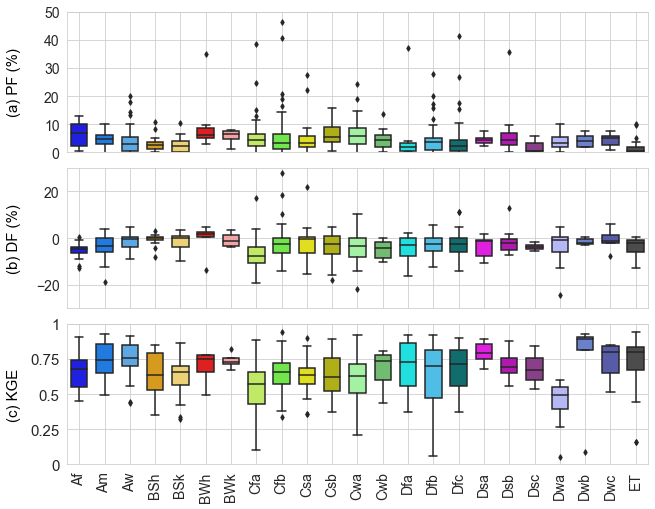

./figures/aggregation_kgc.pdf is saved.
./figures/aggregation_kgc.png is saved.


In [18]:
# KGC color scheme
code2 = pd.read_excel('./data/koppen_geiger_classification/code_rgb.xlsx').set_index('Code')
csch = code2.loc[np.unique(data['kgc2']), ['Red','Green','Blue']].values

# Figure setting
sns.set_style("whitegrid")
sns.set_palette(csch/255)
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(9,7), 
                         sharex=True, sharey=False,
                         gridspec_kw={'height_ratios':[1,1,1]})
# Plotting
name = ['(a) PF (%)', '(b) DF (%)', '(c) KGE']
for (i, el) in enumerate(['PF', 'DF', 'KGE']):
    ax = axes.flatten('F')[i]
    sns.boxplot(ax=ax, x='kgc2', y=el, data=data,
                order = np.unique(data['kgc2']),
                width=0.65, linewidth=1.5, fliersize=4)
    ax.set(xlabel="", ylabel="")
    ax.annotate(name[i], [-0.09,0.5], xycoords='axes fraction', rotation=90,
                color='k', ha='center', va='center', fontfamily='sans-serif', fontsize=15)
    ax.xaxis.grid(True)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, fontname='arial', rotation=90)
    if el == 'KGE':
        ax.set_ylim([0, 1])
        ax.set_yticks(np.arange(0,1.1,0.25))
        ax.set_yticklabels(['0','0.25','0.5','0.75','1'], fontsize=15, fontname='arial')
    elif el == 'PF':
        ax.set_ylim([0, 50])
    elif el == 'DF':
        ax.set_ylim([-30, 30])
        ax.tick_params(axis='y', which='major')
fig.tight_layout(pad=0.7)
plt.show()

if True:
    fn_save = './figures/aggregation_kgc.pdf'
    fig.savefig(fn_save, bbox_inches='tight')
    print('%s is saved.' % fn_save)
    fn_save = './figures/aggregation_kgc.png'
    fig.savefig(fn_save, bbox_inches='tight')
    print('%s is saved.' % fn_save)

In [8]:
data['I'] = data['DF']/data['PF']

In [9]:
data['I'].max()

184.32573036726967